<a href="https://colab.research.google.com/github/legiov/project-3-EDA/blob/main/EDA_Project_3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импрот библиотек

In [7]:
!pip install category_encoders

In [43]:
import pandas as pd
import re
import numpy as np
import ast
import sys
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
import category_encoders as ce
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

#Чтение данных

In [9]:
hotels = pd.read_csv('hotels.csv')
hotels.head(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
5,Via Mecenate 121 20138 Milan Italy,105,12/30/2015,8.0,Novotel Milano Linate Aeroporto,France,Nothing,2,1607,Very nice hotel Price is excellent when compa...,16,1,10.0,"[' Business trip ', ' Solo traveler ', ' Super...",582 day,45.448188,9.257046
6,97 Cromwell Road Kensington and Chelsea London...,854,5/18/2017,7.8,Holiday Inn London Kensington Forum,United Kingdom,Nothing it was lovely,6,3867,Very central location 2 minutes walk from Glo...,29,4,9.6,"[' Leisure trip ', ' Couple ', ' Double Room N...",77 days,51.494231,-0.185114
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,1/23/2017,8.3,Mercure Josefshof Wien,United Kingdom,The communal areas are a bit soul less and th...,40,2526,The location is good for transport links espe...,107,39,8.3,"[' Leisure trip ', ' Couple ', ' Superior Doub...",192 day,48.208563,16.354169
8,190 Queen s Gate Kensington and Chelsea London...,227,11/24/2015,8.6,The Gore Hotel Starhotels Collezione,United Kingdom,undergoing refurbishment no tea coffer in roo...,30,968,staff very good location wonderful,7,3,8.3,"[' Leisure trip ', ' Couple ', ' Double Room '...",618 day,51.500198,-0.179536
9,Holland Park Avenue Kensington and Chelsea Lon...,843,2/2/2016,7.8,Hilton London Kensington Hotel,United Kingdom,I advised it was for my husbands birthday and...,47,3801,No Positive,0,1,6.7,"[' Leisure trip ', ' Couple ', ' Twin Hilton G...",548 day,51.505108,-0.213266


#Работа с данными

Считаем числовое значение количества дней

In [10]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda value: np.int64(re.search('\d+', value).group(0)))

Отвечаем на вопрос сколько тегов

In [11]:
tags = set();

def parse_tags(value, tags):
  cur_tags = set(map(str.strip, ast.literal_eval(value)))
  tags.update(cur_tags)

hotels['tags'].apply(lambda value: parse_tags(value, tags))

print(f"Количество тэгов: {len(tags)}")

Количество тэгов: 2368


Похоже, что тэги разбиты на 5 категорий: тип поездки, количество путешествий, тип номера, количество ночей, и как отправлено сообщение. Попробуем собрать отдельно по категориям и проанализировать их.

In [12]:
cp_hotels = hotels.copy()
def parse_tags_values(value, index):
  index_shift= 0
  cur_tags = list(map(str.strip, ast.literal_eval(value)))
  # В некоторых строках нет первого тега, смещаем индекс на 1 вправо
  if(cur_tags[0] not in ['Leisure trip', 'Business trip']):
    if index == 0:
      return '---'
    index = index - 1
    #index_shift = index_shift + 1


  #if cur_tags[1 - cu]
  return cur_tags[index] if len(cur_tags) > index else '---'

#print(parse_tags_values("[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"))
cp_hotels['trip_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 0))
cp_hotels['trip_travelers_count'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 1))
cp_hotels['trip_room_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 2))
cp_hotels['trip_days_count'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 3))
cp_hotels['from_mobile'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 4))



In [13]:
cp_hotels['trip_type'].value_counts()

Leisure trip     312768
Business trip     61846
---               12189
Name: trip_type, dtype: int64

In [14]:
cp_hotels['trip_travelers_count'].value_counts()

Couple                        188672
Solo traveler                  81072
Group                          48982
Family with young children     45671
Family with older children     19731
Travelers with friends          1630
With a pet                      1045
Name: trip_travelers_count, dtype: int64

In [15]:
cp_hotels['trip_room_type'].value_counts().head(100)

Double Room                               26328
Standard Double Room                      24099
Superior Double Room                      23490
Deluxe Double Room                        18579
Double or Twin Room                       16760
                                          ...  
Double Room 1 Adult                         482
Double Room with View                       478
Art King Room                               467
Executive King Room with Lounge Access      451
Standard King Room                          450
Name: trip_room_type, Length: 100, dtype: int64

In [16]:
cp_hotels['trip_days_count'].value_counts().head(50)

Stayed 1 night                  144940
Stayed 2 nights                  99976
Stayed 3 nights                  71823
Stayed 4 nights                  35672
Stayed 5 nights                  15578
Stayed 6 nights                   7386
Stayed 7 nights                   5537
Stayed 8 nights                   1907
Stayed 9 nights                    963
Stayed 10 nights                   661
Couple                             513
Stayed 11 nights                   305
Stayed 12 nights                   216
Stayed 14 nights                   183
Stayed 13 nights                   174
Family with young children         150
---                                144
Solo traveler                      139
Group                               99
Stayed 15 nights                    87
Family with older children          67
Stayed 16 nights                    38
Stayed 17 nights                    27
Stayed 18 nights                    24
Stayed 19 nights                    23
Stayed 21 nights         

In [17]:
cp_hotels['from_mobile'].value_counts().head(50)

Submitted from a mobile device         230085
---                                    155675
Double or Twin Room                        60
Superior Double Room                       57
Double Room                                55
Standard Double Room                       50
Classic Double Room                        45
Deluxe Double Room                         40
2 rooms                                    36
Stayed 1 night                             28
Superior Double or Twin Room               26
Classic Room                               23
Standard Double or Twin Room               22
Stayed 2 nights                            22
Double or Twin Room 1 2 Adults             16
Classic Double or Twin Room                15
Twin Room                                  14
Deluxe Double or Twin Room                 13
Executive Double Room                      13
Stayed 3 nights                            13
Deluxe Room                                12
Standard Room                     

**вывод по тэгам** - т.к. тэги не всегда расположены в одинаковом порядке мы потеряем часть данных если попытаемся парсить тэги опираясь на их порядок. Поэтому выделим группы для 1, 2, 4 и 5 тэгов, а остальные скинем в 3.

In [18]:

def parse_tags(value):
  return list(map(str.strip, ast.literal_eval(value)))

def parse_tags_trip_type(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_trip_type(tag):
      return tag

  return '---'

def parse_tags_travelers_type(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_travelers_type(tag):
      return tag

  return '---'

def parse_tags_trip_days_count(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_days_count(tag):
      return tag

  return '---'

def parse_tags_from_mobile(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_from_mobile(tag):
      return 1

  return 0

def parse_tags_room_type(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if not is_days_count(tag) and not is_trip_type(tag) and not is_travelers_type(tag) and not is_from_mobile(tag):
      return tag

  return '---'

def is_trip_type(tag):
  if(tag in ['Leisure trip', 'Business trip']):
    return True
  
  return False

def is_travelers_type(tag):
  if(tag in ['Couple', 'Solo traveler', 'Family with young children', 'Group',
       'Family with older children', 'Travelers with friends',
       'With a pet']):
    return True
  return False

def is_days_count(tag):
  return 'Stayed ' in tag

def is_from_mobile(tag):
  return tag == 'Submitted from a mobile device'

#print(parse_tags_values("[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"))
hotels['trip_type'] = hotels['tags'].apply(lambda value: parse_tags_trip_type(value))
hotels['trip_travelers_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_travelers_type(value))
hotels['trip_room_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_room_type(value))
hotels['trip_days_count'] = cp_hotels['tags'].apply(lambda value: parse_tags_trip_days_count(value))
hotels['from_mobile'] = cp_hotels['tags'].apply(lambda value: parse_tags_from_mobile(value))

In [19]:
hotels['trip_type'].value_counts()

Leisure trip     313593
Business trip     61989
---               11221
Name: trip_type, dtype: int64

In [20]:
hotels['trip_travelers_type'].value_counts()

Couple                        188672
Solo traveler                  81072
Group                          48982
Family with young children     45671
Family with older children     19731
Travelers with friends          1630
With a pet                      1045
Name: trip_travelers_type, dtype: int64

In [21]:
hotels['trip_days_count'].value_counts().head(50)

Stayed 1 night      145373
Stayed 2 nights     100263
Stayed 3 nights      72000
Stayed 4 nights      35748
Stayed 5 nights      15611
Stayed 6 nights       7399
Stayed 7 nights       5549
Stayed 8 nights       1910
Stayed 9 nights        966
Stayed 10 nights       663
Stayed 11 nights       306
Stayed 12 nights       217
Stayed 14 nights       184
Stayed 13 nights       174
---                    146
Stayed 15 nights        87
Stayed 16 nights        38
Stayed 17 nights        27
Stayed 18 nights        24
Stayed 19 nights        23
Stayed 21 nights        19
Stayed 20 nights        17
Stayed 27 nights        10
Stayed 30 nights        10
Stayed 22 nights         8
Stayed 28 nights         7
Stayed 26 nights         6
Stayed 23 nights         6
Stayed 24 nights         5
Stayed 25 nights         4
Stayed 29 nights         3
Name: trip_days_count, dtype: int64

In [22]:
hotels['trip_room_type'].value_counts().head(100)

Double Room                               26386
Standard Double Room                      24151
Superior Double Room                      23550
Deluxe Double Room                        18623
Double or Twin Room                       16824
                                          ...  
Double Room with View                       478
Art King Room                               467
Executive King Room with Lounge Access      452
Standard King Room                          450
Premium Double Room                         449
Name: trip_room_type, Length: 100, dtype: int64

In [23]:
hotels['from_mobile'].value_counts()

1    230778
0    156025
Name: from_mobile, dtype: int64

Теперь данные из тэгов гораздо валиднее, с ними можно работать дальше

**Поработаем с данными**

Из колонок с длительностью путешествия достанем количество

In [24]:

def parse_days(value):
  val = re.search('\d+', value)
  if val == None:
    return val

  return np.int64(val.group(0))
hotels['trip_days_count'] = hotels['trip_days_count'].apply(parse_days)

Используем OneHotEncoder для trip_type, trip_travelers_type

In [25]:
enc = ce.OneHotEncoder(cols=['trip_type', 'trip_travelers_type'])

enc_data  = enc.fit_transform(hotels[['trip_type', 'trip_travelers_type']])
hotels_1 = pd.concat([hotels, enc_data], axis=1)

**удаляем дубли**

In [26]:
hotels_2 = hotels_1.drop_duplicates()
print(hotels_1.shape[0])
print(hotels_2.shape[0])

386803
386496


**Заполняем пропуски**

In [27]:
tmp = hotels_2.isnull().sum()
tmp

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
trip_type                                        0
trip_travelers_type                              0
trip_room_type                 

In [82]:
hotels_3 = hotels_2.fillna({
    'lat': hotels_2['lat'].median(),
    'lng': hotels_2['lng'].median(),
    'trip_days_count': hotels_2['trip_days_count'].median()
})

In [83]:
tmp = hotels_3.isnull().sum()
tmp

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
trip_type                                     0
trip_travelers_type                           0
trip_room_type                                0
trip_days_count                         

Преобразуем колонку trip_room_type с помощью BinaryEncoder

In [84]:
enc = ce.BinaryEncoder(cols=['trip_room_type'])

enc_data  = enc.fit_transform(hotels[['trip_room_type']])
hotels_4 = pd.concat([hotels_3, enc_data], axis=1)

In [85]:
hotels_4.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,trip_room_type_2,trip_room_type_3,trip_room_type_4,trip_room_type_5,trip_room_type_6,trip_room_type_7,trip_room_type_8,trip_room_type_9,trip_room_type_10,trip_room_type_11
0,Stratton Street Mayfair Westminster Borough Lo...,581.0,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3.0,1994.0,Staff were amazing,...,0,0,0,0,0,0,0,0,0,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299.0,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3.0,1361.0,location,...,0,0,0,0,0,0,0,0,1,0


In [86]:
hotels_4['review_date'] = pd.to_datetime(hotels_4['review_date'])

In [87]:
hotels_4['days_last'] = (datetime.now() - hotels_4['review_date']).dt.days

In [126]:
hotels_5 = hotels_4.drop('review_date', axis=1)

In [127]:
enc = ce.BinaryEncoder(cols=['reviewer_nationality'])

enc_data  = enc.fit_transform(hotels[['reviewer_nationality']])
hotels_5 = pd.concat([hotels_5, enc_data], axis=1)

#Отбор признаков

**Оценим мультиколериальность**

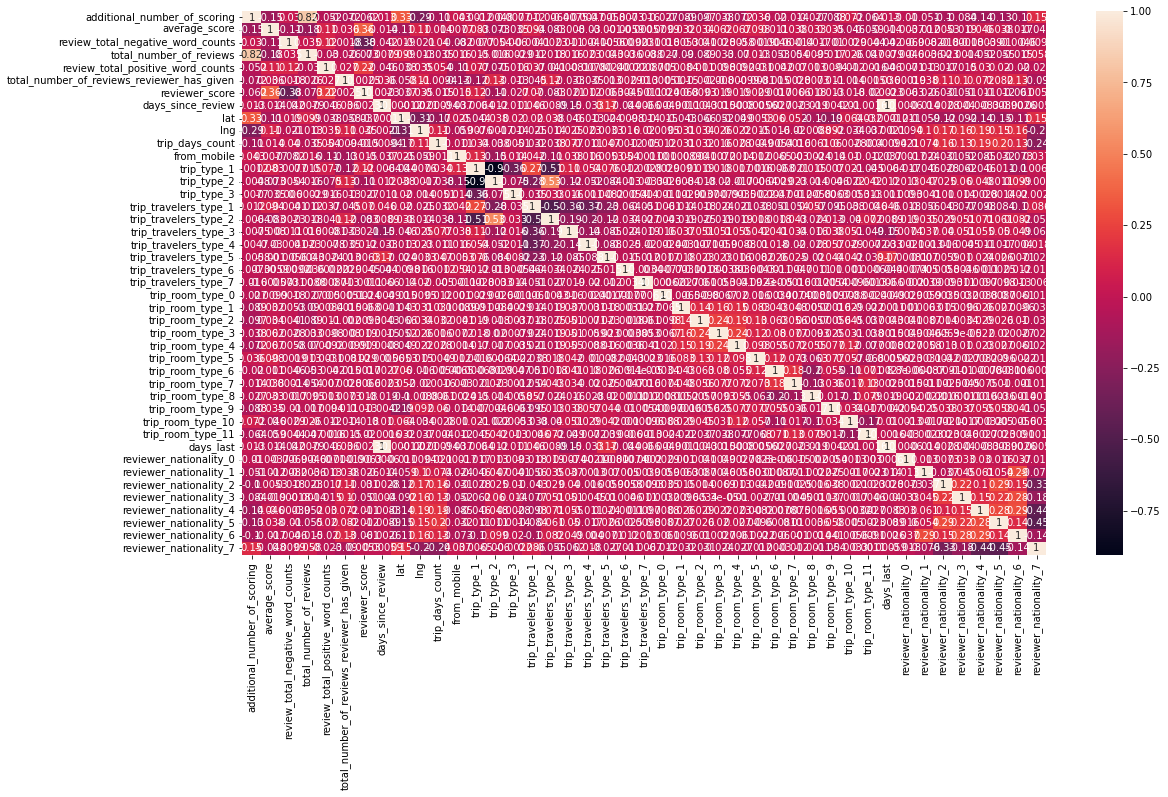

In [128]:
plt.figure(figsize=(18, 10))
sns.heatmap(hotels_5.corr(), annot=True)

Можно удалить колонки: total_number_of_reviews, days_since_review, trip_type_2

In [129]:
hotels_6 = hotels_5.drop(['total_number_of_reviews', 'days_since_review', 'trip_type_2'], axis=1)

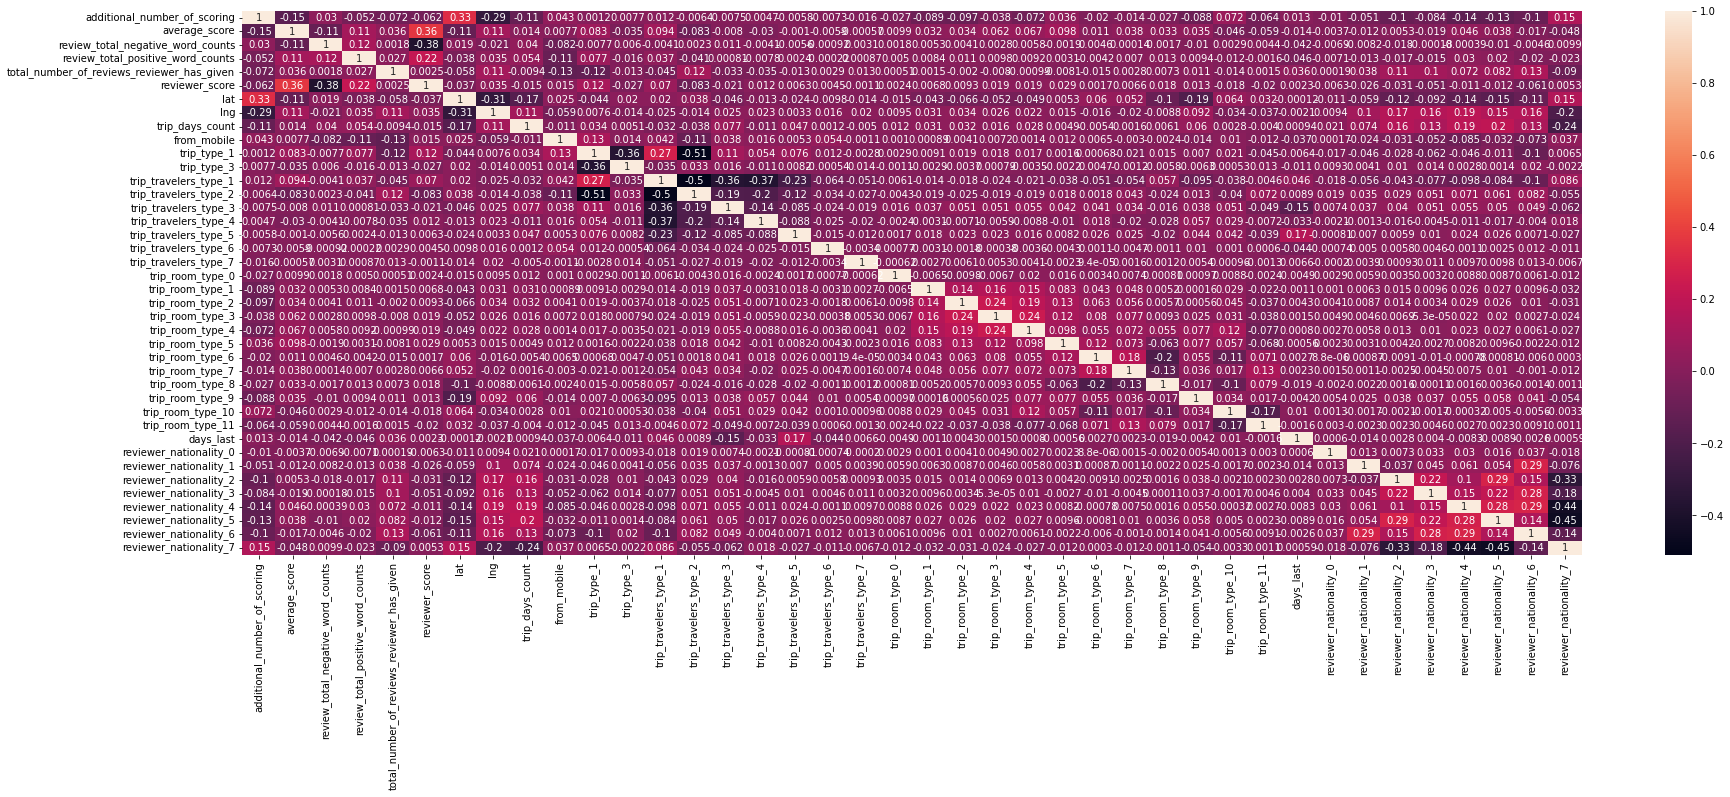

In [95]:
plt.figure(figsize=(30, 10))
sns.heatmap(hotels_6.corr(), annot=True)

In [130]:
hotels_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  float64
 2   average_score                               386496 non-null  float64
 3   hotel_name                                  386496 non-null  object 
 4   reviewer_nationality                        386496 non-null  object 
 5   negative_review                             386496 non-null  object 
 6   review_total_negative_word_counts           386496 non-null  float64
 7   positive_review                             386496 non-null  object 
 8   review_total_positive_word_counts           386496 non-null  float64
 9   total_number_of_reviews_reviewer_has_given  386496 non-null  float64
 

In [131]:
hotels_final = hotels_6.copy()

In [132]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels_final.columns if hotels_final[s].dtypes == 'object']
hotels_final.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
hotels_final = hotels_final.fillna(0)

In [133]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_final.drop(['reviewer_score'], axis = 1)  
y = hotels_final['reviewer_score'] 

**Оценим влияние колонок на результат**

In [118]:
# непрерывные признаки
num_cols = ['total_number_of_reviews_reviewer_has_given', 
            'review_total_negative_word_counts',
            'additional_number_of_scoring',
            'days_last'
            ]

# категориальные признаки
cat_cols = ['average_score', 'lat', 'reviewer_nationality_1','reviewer_nationality_2','reviewer_nationality_3', 'reviewer_nationality_4']

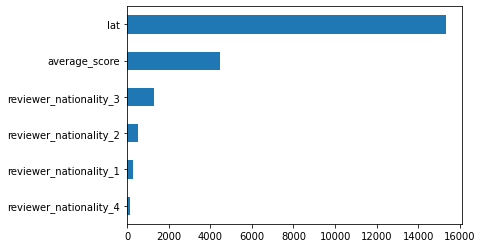

In [119]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [111]:
#удалим свойства reviewer_nationality_4,1,2
#X = X.drop(['reviewer_nationality_1','reviewer_nationality_2', 'reviewer_nationality_4'], axis=1)
#Удалиние приводит к ухудшению результата

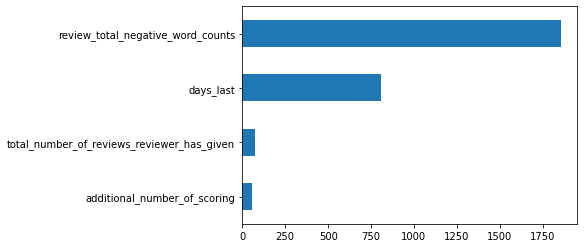

In [134]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [121]:
#удалим свойства 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring',
#X = X.drop(['total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring'], axis=1)
#Удаление приводит к ухудшению результата

In [135]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [136]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [137]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13562212122535064


Небольшой бонус:
